


# 1. Du texte brut aux IDs (pipeline de base)

Objectif : illustrer le début du pipeline :

**Texte → Tokenisation → IDs entiers**

- Les modèles ne voient que des entiers, jamais du texte brut.
- Les tokens ne sont PAS forcément des mots entiers (BPE).
- Les IDs sont ce que le modèle voit en entrée.


In [19]:
from transformers import AutoTokenizer

# On choisit un modèle "classique" dont on peut récupérer le tokenizer et les embeddings.
# Ici : GPT-2 (anglais), mais on pourrait utiliser un autre modèle (ex : "distilbert-base-uncased").
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

text = "Paris is the capital of France."

print("Texte brut :")
print(text)

# 1) Tokenisation (sous-mots BPE)
tokens = tokenizer.tokenize(text)
print("\nTokens :")
print(tokens)

# 2) Conversion en IDs entiers
ids = tokenizer.encode(text)  # liste d'entiers
print("\nIDs :")
print(ids)

print("\nLongueur de la séquence :", len(ids))


Texte brut :
Paris is the capital of France.

Tokens :
['Paris', 'Ġis', 'Ġthe', 'Ġcapital', 'Ġof', 'ĠFrance', '.']

IDs :
[40313, 318, 262, 3139, 286, 4881, 13]

Longueur de la séquence : 7


# Remarques:
    
- On suitle schéma sur du cours : Texte → Tokenisation → IDs entiers
- Les tokens ne sont PAS forcément des mots entiers (BPE).
- Les IDs sont ce que le modèle voit, plus jamais les caractères.

# 2. De IDs à embeddings (vecteurs continus)

On applique la matrice d'embedding \(E\) :  
chaque ID (token) est transformé en un vecteur réel de dimension \(d\).

- \(E\) a une taille \((V, d)\) : vocabulaire × dimension.
- On n'affiche pas toute la matrice, seulement les vecteurs des tokens de **notre phrase**.
- Pour chaque token, on obtient un vecteur dense \(e_t \in \mathbb{R}^d\).


In [20]:
from transformers import AutoModel
import torch

# On charge le modèle pour récupérer la matrice d'embedding
model = AutoModel.from_pretrained(model_name)

# La couche d'embedding d'entrée (tokens -> vecteurs)
embedding_layer = model.get_input_embeddings()

print("Couche d'embedding :")
print(embedding_layer)

# On convertit nos IDs en tenseur (batch de taille 1)
ids_tensor = torch.tensor([ids])  # shape : (1, T)

# Passage par la couche d'embedding
embeddings = embedding_layer(ids_tensor)   # shape : (1, T, d)

print("\nTenseur des embeddings :")
print("shape =", embeddings.shape)  # (1, T, d)

# Pour plus de lisibilité, on retire la dimension batch
emb = embeddings[0]   # shape : (T, d)

print("Shape emb (sans batch) :", emb.shape)


Couche d'embedding :
Embedding(50257, 768)

Tenseur des embeddings :
shape = torch.Size([1, 7, 768])
Shape emb (sans batch) : torch.Size([7, 768])


## Remarques:
    
- La matrice 𝐸 a la taille (𝑉,𝑑) (vocabulaire × dimension).

- Ici on ne la voit pas en entier, mais on en extrait juste les vecteurs des tokens de notre phrase.

- On obtient pour chaque token un vecteur de dimension d (souvent 768, 1024, 1280…).

# 3. Embeddings de tokens + positionnels = entrée du Transformer

On forme :

\[
z_t = e_t + p_t
\]

où :

- \(e_t\) = embedding du token (sémantique),
- \(p_t\) = embedding de position (indice dans la séquence),
- \(z_t\) = vecteur final envoyé dans le bloc Transformer.


In [21]:
# On repart des tenseurs déjà calculés
# ids_tensor : shape (1, T)
# embeddings : shape (1, T, d)  -> ce sont nos e_t

token_emb = embeddings             # (1, T, d)
seq_len = ids_tensor.size(1)       # longueur T de la séquence

# 1) Création des positions [0, 1, 2, ..., T-1]
positions = torch.arange(seq_len, dtype=torch.long).unsqueeze(0)  # shape : (1, T)

# 2) Embeddings positionnels (GPT-2 : attribut model.wpe)
position_embeddings = model.wpe(positions)   # shape : (1, T, d)

# 3) Somme e_t + p_t = z_t
z = token_emb + position_embeddings          # shape : (1, T, d)

print("token_emb shape       :", token_emb.shape)
print("position_embeddings   :", position_embeddings.shape)
print("z (entrée Transformer):", z.shape)


token_emb shape       : torch.Size([1, 7, 768])
position_embeddings   : torch.Size([1, 7, 768])
z (entrée Transformer): torch.Size([1, 7, 768])


# 4. Visualisation du vecteur d'embedding

Chaque token est un vecteur de dimension \(d\).  
On va tracer les composantes de ce vecteur pour un token donné.


Tokens de la phrase :
['Paris', 'Ġis', 'Ġthe', 'Ġcapital', 'Ġof', 'ĠFrance', '.']


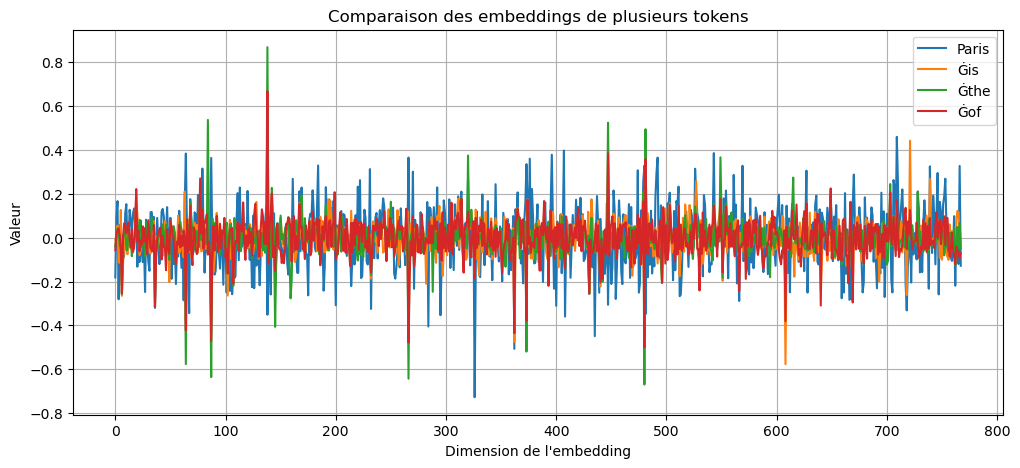

In [27]:
import matplotlib.pyplot as plt

# On récupère les tokens associés aux IDs (pour les afficher)
tokens_sentence = tokenizer.convert_ids_to_tokens(ids_tensor[0])

print("Tokens de la phrase :")
print(tokens_sentence)

# Sélectionnons 3 ou 4 tokens à comparer
# (tu peux ajuster les index selon ta phrase)
token_indices = [0, 1, 2, 4]   # ex : Paris / is / the / capital

plt.figure(figsize=(12,5))

for idx in token_indices:
    vec = emb[idx].detach().numpy()
    plt.plot(vec, label=tokens_sentence[idx])  # matplotlib gère les couleurs automatiquement

plt.title("Comparaison des embeddings de plusieurs tokens")
plt.xlabel("Dimension de l'embedding")
plt.ylabel("Valeur")
plt.legend()
plt.grid(True)
plt.show()


# 5. Comparer plusieurs embeddings de tokens

On trace maintenant plusieurs vecteurs d'embeddings sur le même graphique,
pour voir que chaque token a une "signature" différente.


Shape emb_words : (8, 768)


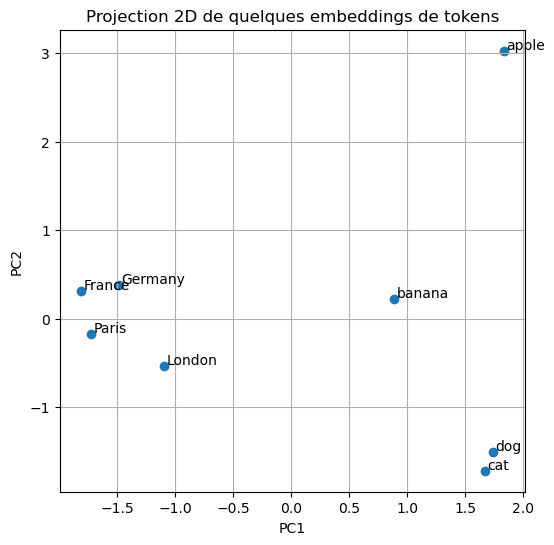

In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch

# Quelques mots pour illustrer la sémantique
words = ["Paris", "France", "London", "Germany", "banana", "apple", "dog", "cat"]

# On récupère l'ID du *premier token* de chaque mot, sans padding
first_token_ids = []
for w in words:
    # encode renvoie une liste d'IDs pour le mot (ou les sous-mots)
    ids_w = tokenizer.encode(w, add_special_tokens=False)
    first_token_ids.append(ids_w[0])

first_token_ids = torch.tensor(first_token_ids)  # shape : (N,)

# Embeddings correspondants pour chaque token
emb_words = embedding_layer(first_token_ids).detach().numpy()  # (N, d)

print("Shape emb_words :", emb_words.shape)

# Réduction de dimension (PCA 2D)
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(emb_words)

plt.figure(figsize=(6,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1])

for (x, y), w in zip(emb_2d, words):
    plt.text(x + 0.02, y + 0.02, w)

plt.title("Projection 2D de quelques embeddings de tokens")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()
